# Pythonで自己相関グラフ(コレログラム)を描く

時系列分析で目にする自己相関グラフですが、Pythonを用いてこれを描く方法がいくつかあります。

ここでは、

* 関数を自作して自己相関を求め、Matplotlibのpyplot.stemを使う方法
* Statsmodelsのplot_acfを使う方法
* Pandasのautocorrelation_plotを使う方法
* Matplotlibのpyplot.acorrを使う方法

を紹介します。

## グラフで使うデータを作る
まずはじめにnumpyを使って時系列データを作ります。

わかりやすいデータにしておきたいので、1から10を3回繰り返す1次元arrayを作ります。

In [1]:
import numpy as np
a = np.arange(1,11)
b = np.tile(a, 3)

In [2]:
b

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

## Matplotlibのpyplot.stemを使う方法

ラグが$k$のデータとの自己相関$r_k$は以下の式で求められます。

$$r_{k} = \frac{\sum\limits_{t=k+1}^T (y_{t}-\bar{y})(y_{t-k}-\bar{y})}
 {\sum\limits_{t=1}^T (y_{t}-\bar{y})^2}$$
 
ここで$T$は含まれる時系列データの数を、$\bar{y}$は時系列データ全体の平均を表しています。

まずはじめにラグが$k$のデータとの自己相関を求める`autocorrelation`関数を作ります。

In [3]:
def autocorrelation(data, k):
    """Returns the autocorrelation of the *k*th lag in a time series data.
    
    Parameters
    ----------
    data : one dimentional numpy array
    k : the *k*th lag in the time series data (index starts at 0)
    """
    
    # yの平均
    y_avg = np.mean(data)
    
    # 分子の計算
    sum_of_covariance = 0
    for i in range(k+1, 30):
        covariance = ( data[i] - y_avg ) * ( data[i-(k+1)] - y_avg )
        sum_of_covariance += covariance
    
    # 分母の計算
    sum_of_denominator = 0
    for u in range(30):
        denominator = ( data[u] - y_avg )**2
        sum_of_denominator += denominator
    
    return sum_of_covariance / sum_of_denominator

これでラグが$k$のデータとの自己相関を出力することができるようになりました。

ひとつ注意しなければいけないのは、numpyのarrayは多くのデータと同様に0から数え始めるので、ここでは$k$の値が先程の式より1つ小さくなります。

4番目のラグ、9番目のラグとの自己相関を求めてみます。

In [4]:
autocorrelation(b, 4)

-0.4292929292929293

In [5]:
autocorrelation(b, 9)

0.6666666666666666

次に自己相関のグラフ化に移ります。

グラフ化するにはそれぞれの自己相関が必要なので、`acorr_data`というリストに先程の関数を使って全ての自己相関を入れていきます。

このときに、グラフ上ではラグのない自身との相関を1として表示させたいので`acorr_data`に「1」を最初に入れておきます。

In [6]:
acorr_data = [1]
for i in range(29):  # ラグをとったデータは29個あるのでrange(29)となります。
    acorr_data.append(autocorrelation(b, i))

後で使いやすいように`acorr_data`をnumpyのarrayに変換しておきます。

In [7]:
acorr_data = np.asarray(acorr_data)

In [8]:
acorr_data

array([ 1.        ,  0.53636364,  0.15757576, -0.13232323, -0.32929293,
       -0.42929293, -0.42828283, -0.32222222, -0.10707071,  0.22121212,
        0.66666667,  0.38484848,  0.14747475, -0.04141414, -0.17777778,
       -0.25757576, -0.27676768, -0.23131313, -0.11717172,  0.06969697,
        0.33333333,  0.23333333,  0.13737374,  0.04949495, -0.02626263,
       -0.08585859, -0.12525253, -0.14040404, -0.12727273, -0.08181818])

次にMatplotlibを使ってこれをグラフ化します。

ここではMatplotlibの[Stem Plot](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.stem.html)と呼ばれるグラフを使います。

<StemContainer object of 3 artists>

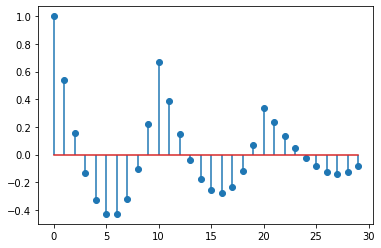

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.stem(np.arange(30), acorr_data, use_line_collection=True)

この`plt.stem`の`use_line_collection`というパラメータは棒の部分の表示の高速化のためのもので、必須ではありません。

このグラフでは、$r_0=1$としているので、横軸の$k$の値は最初の式と一致します。

## Statsmodelsのplot_acfを使う方法

上の例では自己相関を求める関数を自作して`b`の自己相関を求め、それらの値を用いてStem Plotを使ってグラフを描きました。

Statsmodelsの`plot_acf`[(リンク)](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)を使うことでこれらを一度に行うことができます。

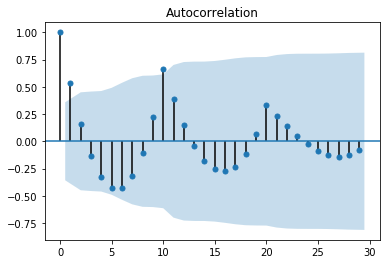

In [10]:
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(b, lags=29);
# 最後のセミコロンは、statsmodelが2つの同じグラフを描くのを防ぐために書いています。
# 参考リンク: https://github.com/statsmodels/statsmodels/issues/1265#issuecomment-383336489
# plt.show() という行を付け加えることで防ぐこともできます。
# 参考リンク: https://momonoki2017.blogspot.com/2018/03/python7.html

グラフに表示されている薄い青の帯はBartlett’s formulaを用いた95%信頼区間です。

`alpha`のパラメータを指定することで信頼区間の幅を変えることができます。

## Pandasのautocorrelation_plotを使う方法

Statsmodelsの`plot_acf`と同様に、Pandasの`autocorrelation_plot`[(リンク)](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#autocorrelation-plot)を使うことで自己相関グラフを描くことができます。

Pandasではnumpyの1次元arrayをPandasのSeriesに変換する必要があります。

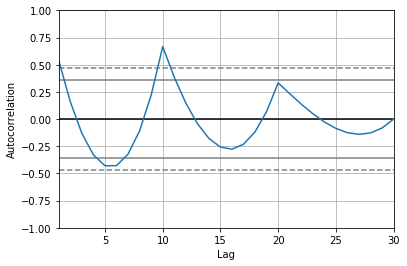

In [11]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(b))

グラフの点線に挟まれている範囲は99%の信頼区間、実線に挟まれている範囲は95%の信頼区間を表しています。

## Matplotlibのpyplot.acorrを使う方法

Matplotlibの`pyplot.acorr`[(リンク)](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.acorr.html)を使うことで、StatsmodelsやPandasと同様にデータから直接グラフを描くことができます。

(array([-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17,
        -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29]),
 array([0.00865801, 0.02510823, 0.04848485, 0.07792208, 0.11255411,
        0.15151516, 0.19393939, 0.23896104, 0.2857143 , 0.33333334,
        0.3030303 , 0.28917748, 0.29090908, 0.3073593 , 0.33766234,
        0.3809524 , 0.43636364, 0.5030303 , 0.5800866 , 0.6666667 ,
        0.5974026 , 0.55324674, 0.53333336, 0.5367965 , 0.56277055,
        0.6103896 , 0.6787879 , 0.76709956, 0.87445885, 1.        ,
        0.87445885, 0.76709956, 0.6787879 , 0.6103896 , 0.56277055,
        0.5367965 , 0.53333336, 0.55324674, 0.5974026 , 0.6666667 ,
        0.5800866 , 0.5030303 , 0.43636364, 0.3809524 , 0.33766234,
        0.3073593 , 0.29090908, 0.28917748, 0.30303

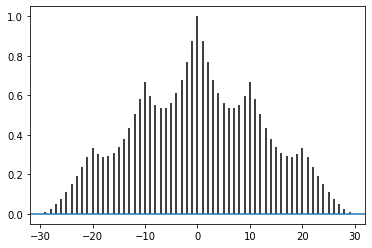

In [12]:
# plt.acorr(b, maxlags=None)
# 上記コードで実行するとエラーになります。
# データをfloatに変えることでエラーを回避することができます。
plt.acorr(b.astype('f'), maxlags=None)

見てわかる通り、今までのグラフとは形が違います。

これは`pyplot.acorr`が[信号処理を念頭においた関数だから](https://stackoverflow.com/a/27558293)とのことです。

`b`のデータから`b`の平均を引いたものを引数として与えることで先程までのグラフと縦軸の値を統一することができます。

(array([-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17,
        -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29]),
 array([-0.08181818, -0.12727273, -0.14040405, -0.12525253, -0.08585858,
        -0.02626263,  0.04949495,  0.13737373,  0.23333333,  0.33333334,
         0.06969697, -0.11717172, -0.23131312, -0.27676767, -0.25757575,
        -0.17777778, -0.04141414,  0.14747475,  0.38484848,  0.6666667 ,
         0.22121212, -0.10707071, -0.32222223, -0.42828283, -0.42929292,
        -0.32929292, -0.13232324,  0.15757576,  0.53636366,  1.        ,
         0.53636366,  0.15757576, -0.13232324, -0.32929292, -0.42929292,
        -0.42828283, -0.32222223, -0.10707071,  0.22121212,  0.6666667 ,
         0.38484848,  0.14747475, -0.04141414, -0.17777778, -0.25757575,
      

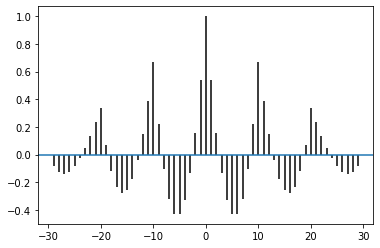

In [13]:
plt.acorr(b.astype('f')-b.mean(), maxlags=None)

Axesの`set_xlim`([リンク](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.set_xlim.html#matplotlib.axes.Axes.set_xlim))を使うことで表示させるx軸の範囲を指定することができます。

(array([-29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17,
        -16, -15, -14, -13, -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,
         -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
         10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
         23,  24,  25,  26,  27,  28,  29]),
 array([-0.08181818, -0.12727273, -0.14040405, -0.12525253, -0.08585858,
        -0.02626263,  0.04949495,  0.13737373,  0.23333333,  0.33333334,
         0.06969697, -0.11717172, -0.23131312, -0.27676767, -0.25757575,
        -0.17777778, -0.04141414,  0.14747475,  0.38484848,  0.6666667 ,
         0.22121212, -0.10707071, -0.32222223, -0.42828283, -0.42929292,
        -0.32929292, -0.13232324,  0.15757576,  0.53636366,  1.        ,
         0.53636366,  0.15757576, -0.13232324, -0.32929292, -0.42929292,
        -0.42828283, -0.32222223, -0.10707071,  0.22121212,  0.6666667 ,
         0.38484848,  0.14747475, -0.04141414, -0.17777778, -0.25757575,
      

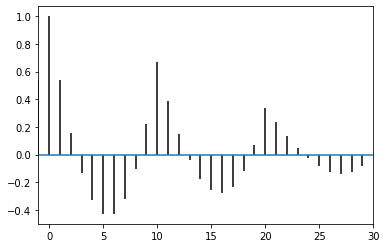

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(-1, 30)
plt.acorr(b.astype('f')-b.mean(), maxlags=None)

## 参考資料

* [Rob J Hyndman and George Athanasopoulos, Forecasting: Principles and Practice: 2.8 Autocorrelation](https://otexts.com/fpp2/autocorrelation.html)
* [もものきとデータ解析をはじめよう: Pythonで時系列分析の練習（7）自己相関](https://momonoki2017.blogspot.com/2018/03/python7.html)
* [Stack Overflow: bug of autocorrelation plot in matplotlib‘s plt.acorr?
](https://stackoverflow.com/questions/27541290/bug-of-autocorrelation-plot-in-matplotlib-s-plt-acorr)
* James H. Stock, Mark W. Watson, Introduction to Econometrics, 3rd Edition, Pearson, 2011, p. 572-575
* [Christoph Hanck, Martin Arnold, Alexander Gerber and Martin Schmelzer, Introduction to Econometrics with R: 14.2 Time Series Data and Serial Correlation](https://www.econometrics-with-r.org/14-2-tsdasc.html)

## 備考
この記事は[クリエイティブ・コモンズ 表示 4.0 国際 ライセンス](https://creativecommons.org/licenses/by/4.0/deed.ja)の下に提供されています。

<a rel="license" href="https://creativecommons.org/licenses/by/4.0/deed.ja"><img alt="クリエイティブ・コモンズ・ライセンス" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>